# Price stock tendency prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import mlflow
import mlflow.sklearn
from tqdm.notebook import trange, tqdm

from DataHelper import *
from Plots import *

# increase plot size
plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

In [2]:
DATA_PATH = './data'
QUOTATION = 'GOOG'
FILE_SUFFIX = '.txt'

In [3]:
PREDICT_N = 1

In [4]:
price_column='Close'
df, feature_names = features_pipeline(f"{DATA_PATH}/{QUOTATION}{FILE_SUFFIX}", predict_n=PREDICT_N,
    price_column=price_column, normalize_features=True)

df.head()

,Date,Open,High,Low,Close,Volume,Adjusted,Difference,PercentageDiff,Tendency,...,MACD,MACD_diff,MACD_signal,BodyLen,BG_L_Band,BG_H_Band,BG_L_Band_Indicator,BG_H_Band_Indicator,ROC,StochOsc
34,2007-02-21,234.042755,238.446243,232.996674,237.041504,11323400.0,237.041504,0.059708,-0.291987,higher,...,0.219622,0.045115,0.193238,-0.978678,-0.876317,-0.908099,-1.0,-1.0,-0.037016,0.121553
35,2007-02-22,238.451233,241.215866,236.309250,237.036530,11530700.0,237.036530,0.078676,-0.226294,lower,...,0.219934,0.041292,0.195071,-0.952758,-0.875409,-0.907822,-1.0,-1.0,-0.039296,0.380027
36,2007-02-23,236.986710,237.584473,233.026566,234.431290,7794200.0,234.431290,0.063125,-0.280156,lower,...,0.219431,0.036300,0.196423,-0.969899,-0.874102,-0.907880,-1.0,-1.0,-0.037298,0.280615
37,2007-02-26,235.532166,236.737656,231.009125,231.596924,7969500.0,231.596924,0.098783,-0.156948,lower,...,0.222953,0.041843,0.198310,-0.919033,-0.871811,-0.908086,-1.0,-1.0,0.030667,0.781263
38,2007-02-27,226.650452,229.041489,222.750076,223.547089,18695300.0,223.547089,0.061672,-0.284877,lower,...,0.224740,0.042168,0.200228,-0.986065,-0.870164,-0.908145,-1.0,-1.0,0.027277,0.663048


### Plots

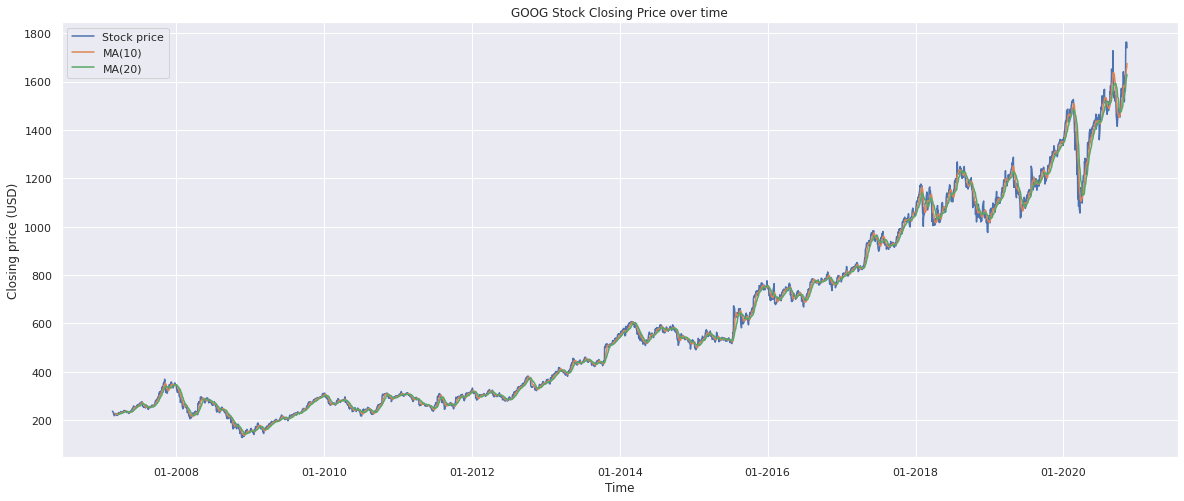

In [5]:
import datetime
import matplotlib.dates as mdates

ax = plot_prices(df.Date, df[price_column], quotation_name=QUOTATION, ma_values = [10, 20])

### Plot histogram differences

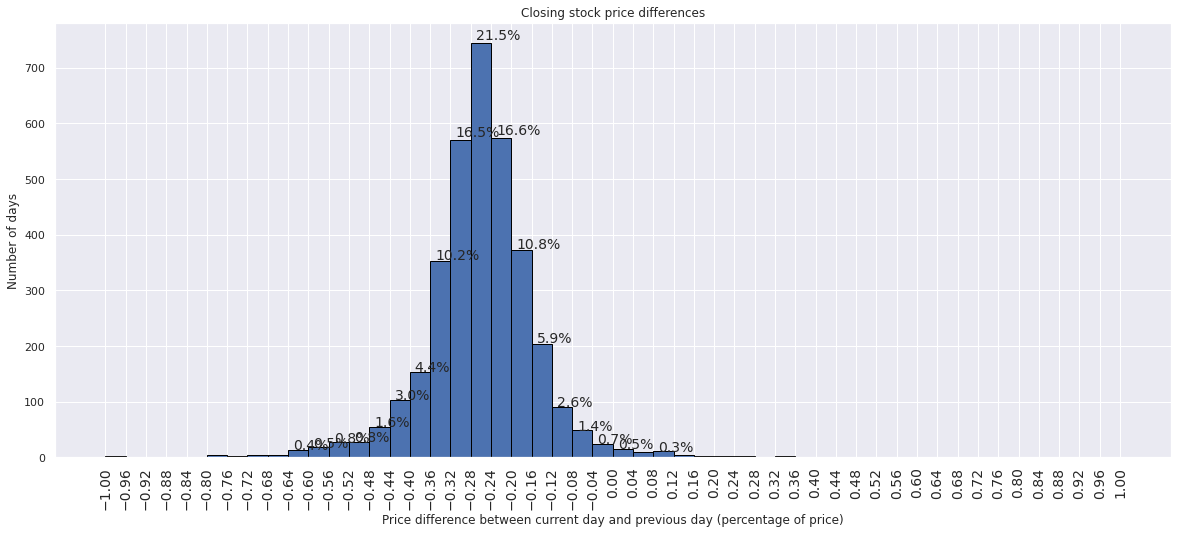

In [6]:
ax = plot_density_hist(df['PercentageDiff'])
plt.show()

### ML Data preparation

In [7]:
df.head()

,Date,Open,High,Low,Close,Volume,Adjusted,Difference,PercentageDiff,Tendency,...,MACD,MACD_diff,MACD_signal,BodyLen,BG_L_Band,BG_H_Band,BG_L_Band_Indicator,BG_H_Band_Indicator,ROC,StochOsc
34,2007-02-21,234.042755,238.446243,232.996674,237.041504,11323400.0,237.041504,0.059708,-0.291987,higher,...,0.219622,0.045115,0.193238,-0.978678,-0.876317,-0.908099,-1.0,-1.0,-0.037016,0.121553
35,2007-02-22,238.451233,241.215866,236.309250,237.036530,11530700.0,237.036530,0.078676,-0.226294,lower,...,0.219934,0.041292,0.195071,-0.952758,-0.875409,-0.907822,-1.0,-1.0,-0.039296,0.380027
36,2007-02-23,236.986710,237.584473,233.026566,234.431290,7794200.0,234.431290,0.063125,-0.280156,lower,...,0.219431,0.036300,0.196423,-0.969899,-0.874102,-0.907880,-1.0,-1.0,-0.037298,0.280615
37,2007-02-26,235.532166,236.737656,231.009125,231.596924,7969500.0,231.596924,0.098783,-0.156948,lower,...,0.222953,0.041843,0.198310,-0.919033,-0.871811,-0.908086,-1.0,-1.0,0.030667,0.781263
38,2007-02-27,226.650452,229.041489,222.750076,223.547089,18695300.0,223.547089,0.061672,-0.284877,lower,...,0.224740,0.042168,0.200228,-0.986065,-0.870164,-0.908145,-1.0,-1.0,0.027277,0.663048


In [8]:
print(feature_names)

['Difference', 'PercentageDiff', 'Tendency', 'SMA(10)', 'SMA(20)', 'EMA(14)', 'EMA_Diff', 'SMA(20) - SMA(10)', 'LowLen', 'RSI(14)', 'GAP', 'RSI_Diff', 'Volume_diff', 'Next', 'MACD', 'MACD_diff', 'MACD_signal', 'BodyLen', 'BG_L_Band', 'BG_H_Band', 'BG_L_Band_Indicator', 'BG_H_Band_Indicator', 'ROC', 'StochOsc']


In [9]:
dataset = df.copy()

#feature_names = ['MACD_signal', 'MACD_diff', 'SMA(10)', 'SMA(20)', 'BG_L_Band', 'BG_H_Band', 'EMA(14)', 'MACD']  + ['Next']

dataset = df.loc[:, feature_names]
#df = df.drop(columns=['Tendency', 'Date', 'Difference'])
for col in dataset.columns:
    dataset[col] = dataset[col].replace({'higher':1, 'stay':0, 'lower':-1})

dataset.head()

,Difference,PercentageDiff,Tendency,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),LowLen,RSI(14),...,MACD,MACD_diff,MACD_signal,BodyLen,BG_L_Band,BG_H_Band,BG_L_Band_Indicator,BG_H_Band_Indicator,ROC,StochOsc
34,0.059708,-0.291987,1,-0.885681,-0.895034,-0.892008,0.152937,-0.163048,-0.969077,-0.076950,...,0.219622,0.045115,0.193238,-0.978678,-0.876317,-0.908099,-1.0,-1.0,-0.037016,0.121553
35,0.078676,-0.226294,-1,-0.885351,-0.894445,-0.891723,0.160181,-0.160759,-0.971654,0.001333,...,0.219934,0.041292,0.195071,-0.952758,-0.875409,-0.907822,-1.0,-1.0,-0.039296,0.380027
36,0.063125,-0.280156,-1,-0.885030,-0.893835,-0.891564,0.156047,-0.158200,-0.952809,-0.035598,...,0.219431,0.036300,0.196423,-0.969899,-0.874102,-0.907880,-1.0,-1.0,-0.037298,0.280615
37,0.098783,-0.156948,-1,-0.884067,-0.892821,-0.890784,0.176337,-0.157872,-0.995007,0.168557,...,0.222953,0.041843,0.198310,-0.919033,-0.871811,-0.908086,-1.0,-1.0,0.030667,0.781263
38,0.061672,-0.284877,-1,-0.883214,-0.892044,-0.890226,0.169076,-0.158684,-0.980673,0.116488,...,0.224740,0.042168,0.200228,-0.986065,-0.870164,-0.908145,-1.0,-1.0,0.027277,0.663048


### Dataset class balance

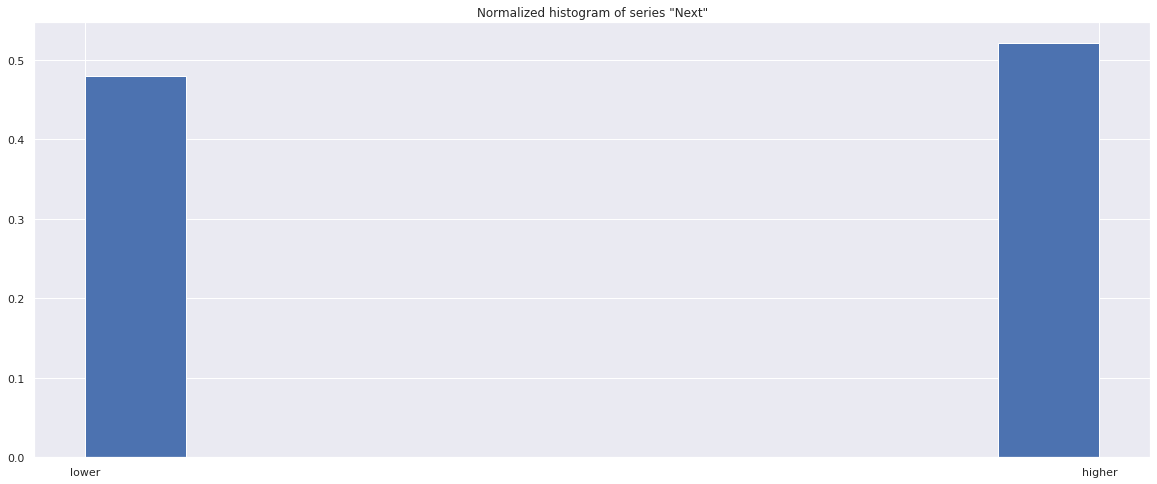

In [23]:
ax = plot_normalized_histogram(dataset.Next)

### Train / Test data 

In [11]:
X = dataset.loc[:, dataset.columns != 'Next']
Y = dataset['Next']

In [12]:
from sklearn.model_selection import train_test_split
TRAIN_RATIO = 0.7

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=TRAIN_RATIO, random_state=42)

print(f"Train size : {len(X_train)}, test size : {len(X_test)} ({(1-TRAIN_RATIO)*100:.0f}%)")

Train size : 2419, test size : 1038 (30%)


## Classifier and evaluation

In [13]:
from sklearn.utils.class_weight import compute_class_weight

USE_CLASS_WEIGHTS = True

if USE_CLASS_WEIGHTS:
    class_weights = compute_class_weight('balanced', np.unique(Y), Y)
    # format as dict
    class_weights = {c:w for c,w in zip(np.unique(Y), class_weights)}

    print(class_weights)
else:
    class_weights = None

{-1: 1.043780193236715, 1: 0.9597445863409217}


c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[-1  1], y=34     -1
35     -1
36     -1
37     -1
38      1
       ..
3486    1
3487   -1
3488    1
3489   -1
3490    1
Name: Next, Length: 3457, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


### Grid Search

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

PERFORM_GRID_SEARCH = False

# default parameters
best_params = {'DTree': {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 1}, 'RandomForest': {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 500}, 'SVM': {'gamma': 'auto'}, 'LR': {'penalty': 'l2', 'C': 1.0}}
param_grid = {
    'DTree':{
        'criterion':('entropy', 'gini'),
        'max_depth':[1,2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
    },
    'RandomForest':{
        'criterion':('entropy', 'gini'),
        'n_estimators':[50,100,200,500],
        'max_depth':[2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
        'max_features':['auto', 'sqrt', 'log2'], 
    },
    'SVM':{
        'C':[1.0],
        'kernel':('linear', 'poly', 'rbf'),
        'gamma':('scale', 'auto'),
    },
    'LR':
    {
        'penalty':('none', 'l2'),
        'C':[0.5, 1.0]
    },   
    
}

if PERFORM_GRID_SEARCH:
    print("Performing grid search...")
    dtree = DecisionTreeClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(dtree, param_grid['DTree'], n_jobs=4)

    
    clf.fit(X_train, Y_train)
    best_params['DTree'] = clf.best_params_

    random_forest = RandomForestClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(random_forest, param_grid['RandomForest'], n_jobs=8)
    clf.fit(X_train, Y_train)
    best_params['RandomForest'] = clf.best_params_

    
    """svm = SVC(random_state=42, class_weight=class_weights, cache_size=4096)
    clf = GridSearchCV(svm, param_grid['SVM'], n_jobs=4, verbose=30)
    clf.fit(X_train, Y_train)
    best_params['SVM'] = clf.best_params_"""
    
    lr = LogisticRegression(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(lr, param_grid['LR'], n_jobs=4)
    clf.fit(X_train, Y_train)


    print(best_params)

### Classifiers

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

clf_dict = {}

clf_dict['DTree'] = DecisionTreeClassifier(**best_params['DTree'], random_state=42, class_weight=class_weights)
clf_dict['RandomForest'] = RandomForestClassifier(**best_params['RandomForest'], random_state=42, class_weight=class_weights)
clf_dict['SVM'] = SVC(**best_params['SVM'], class_weight=class_weights)
clf_dict['LR'] = LogisticRegression(**best_params['LR'], class_weight=class_weights)

### Training

In [16]:
print("Training...")

for clf_label, clf in clf_dict.items():
    clf.fit(X_train, Y_train)
    
print("Training done.")

Training...
Training done.


[DTree] Accuracy : 0.50, F1 : 0.56
[RandomForest] Accuracy : 0.50, F1 : 0.50
[SVM] Accuracy : 0.50, F1 : 0.50
[LR] Accuracy : 0.51, F1 : 0.52


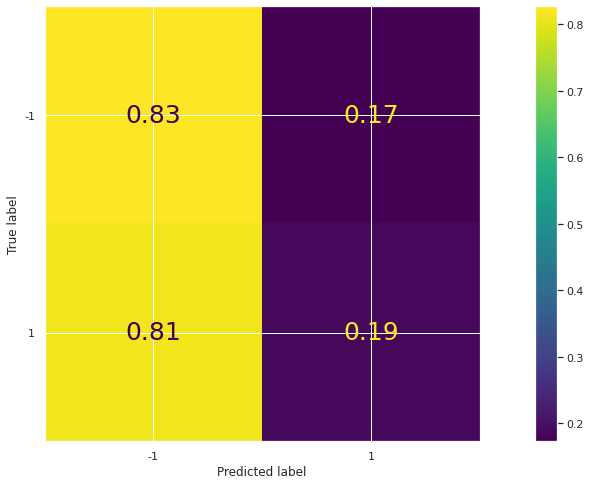

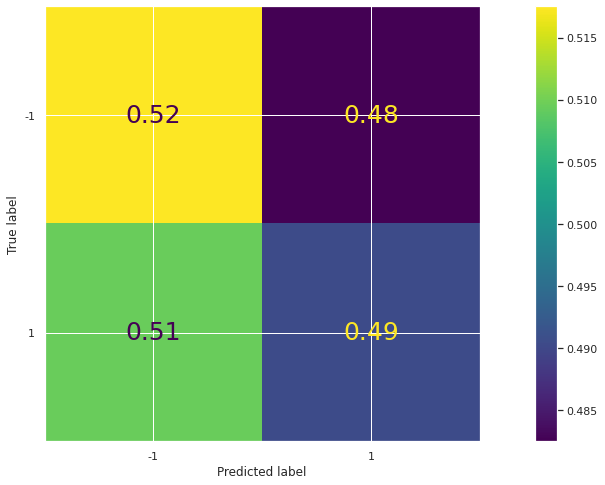

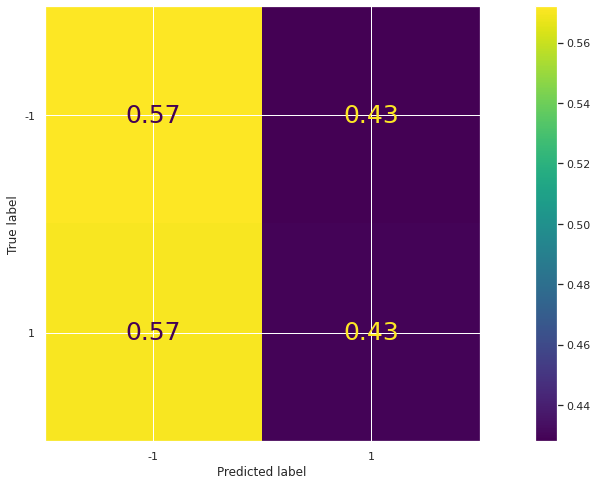

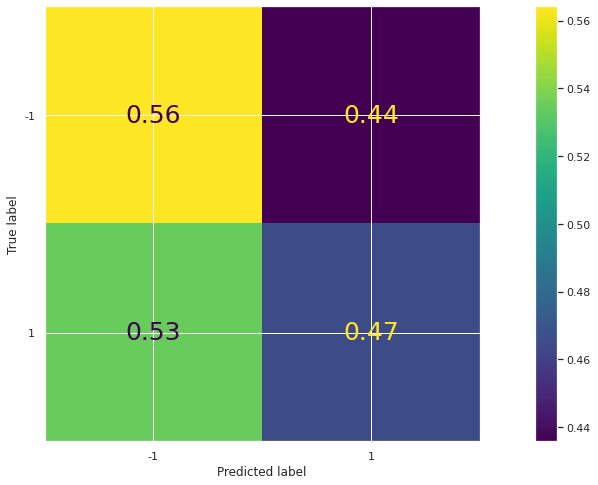

In [17]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score

for clf_label, clf in clf_dict.items():
    with mlflow.start_run(run_name=clf_label):
        Y_pred = clf.predict(X_test)
        
        accuracy = accuracy_score(Y_pred, Y_test)
        f1 = f1_score(Y_pred, Y_test, average='weighted')
        


        for param, val in best_params[clf_label].items():
            mlflow.log_param(param, val)
        mlflow.log_metric('acc', accuracy)
        mlflow.log_metric('f1', f1)
        mlflow.sklearn.log_model(clf, "sklearn model")
    
    print(f"[{clf_label}] Accuracy : {accuracy:.2f}, F1 : {f1:.2f}")
    plot_cfm(clf, X_test, Y_test, normalize='true')

|--- MACD_diff <= -0.06
|   |--- class: 1
|--- MACD_diff >  -0.06
|   |--- class: -1



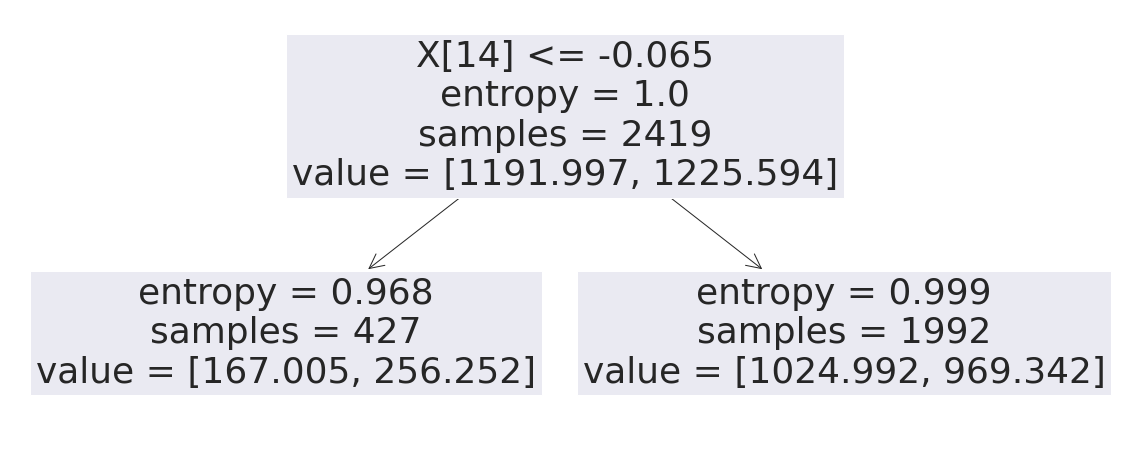

In [18]:
from sklearn import tree
from sklearn.tree import export_text
dtree = clf_dict['DTree']

#print(dtree.feature_importances_)
tree.plot_tree(dtree)

#print(dtree.tree_.feature)



rules = export_text(dtree, feature_names=(list(X_train.columns)))

print(rules)

In [21]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean, std


#feature_names = ['Volume', 'Volume_diff', 'PercentageDiff', 'Next']
dataset = df.copy()
dataset = df.loc[:, feature_names]
print(dataset.head())
X = dataset.loc[:, dataset.columns != 'Next']
Y = dataset['Next']


model = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

    Difference  PercentageDiff Tendency   SMA(10)   SMA(20)   EMA(14)  \
34    0.059708       -0.291987   higher -0.885681 -0.895034 -0.892008   
35    0.078676       -0.226294    lower -0.885351 -0.894445 -0.891723   
36    0.063125       -0.280156    lower -0.885030 -0.893835 -0.891564   
37    0.098783       -0.156948    lower -0.884067 -0.892821 -0.890784   
38    0.061672       -0.284877    lower -0.883214 -0.892044 -0.890226   

    EMA_Diff  SMA(20) - SMA(10)    LowLen   RSI(14)  ...      MACD  MACD_diff  \
34  0.152937          -0.163048 -0.969077 -0.076950  ...  0.219622   0.045115   
35  0.160181          -0.160759 -0.971654  0.001333  ...  0.219934   0.041292   
36  0.156047          -0.158200 -0.952809 -0.035598  ...  0.219431   0.036300   
37  0.176337          -0.157872 -0.995007  0.168557  ...  0.222953   0.041843   
38  0.169076          -0.158684 -0.980673  0.116488  ...  0.224740   0.042168   

    MACD_signal   BodyLen  BG_L_Band  BG_H_Band  BG_L_Band_Indicator  \
34

In [20]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
selected = sel.fit_transform(X)

print(X.shape)
print(selected.shape)

ValueError: could not convert string to float: 'higher'